c:\Users\Admin\anaconda3\envs\stt_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training data size: 500
Test data size: 500
=== dataset sample ===
sample 1:
text: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was cons

c:\Users\Admin\anaconda3\envs\stt_env\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Train loss: 0.0543
Training Accuracy: 100.00%
Test Accuracy: 100.00%

Epoch 2/3
Train loss: 0.0005
Training Accuracy: 100.00%
Test Accuracy: 100.00%

Epoch 3/3
Train loss: 0.0004
Training Accuracy: 100.00%
Test Accuracy: 100.00%
=== model result sample ===
input text: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn't match the background, and painfully one-dimensional characters cannot be overcome with a 'sci-fi' setting. (I'm sure there are those of you out there who think Babylon 5 is good sci-fi TV. It's not. It's clich√©d and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious

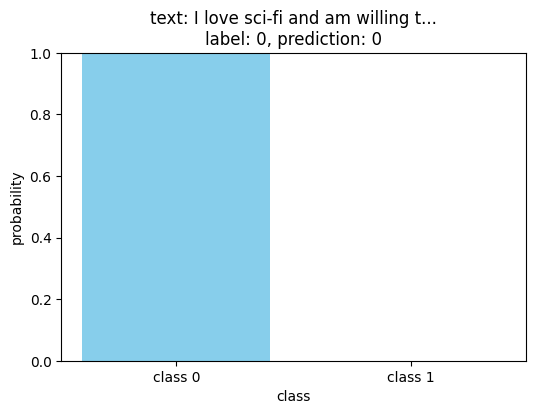

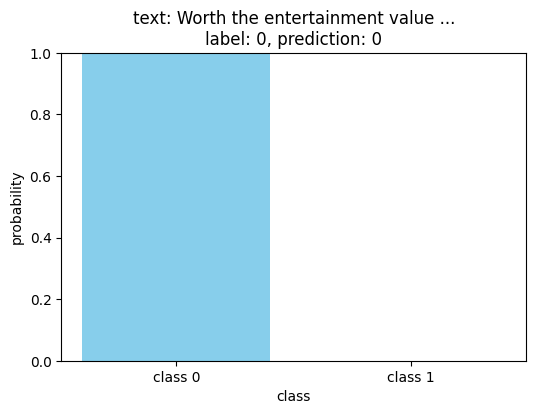

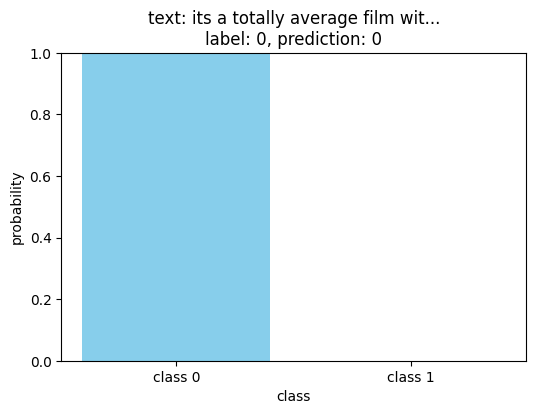

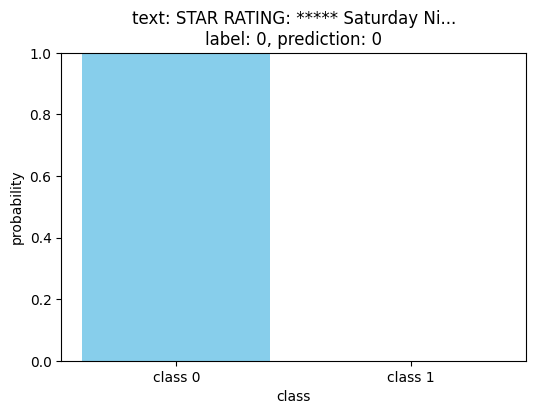

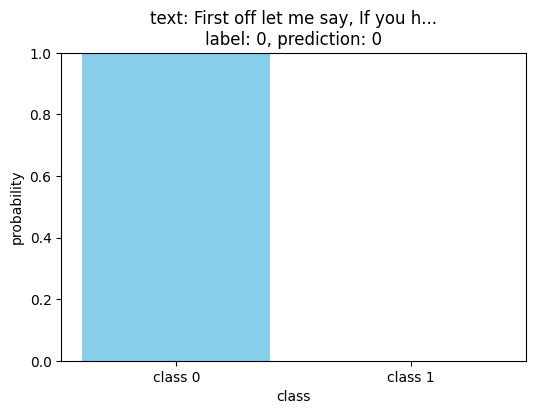

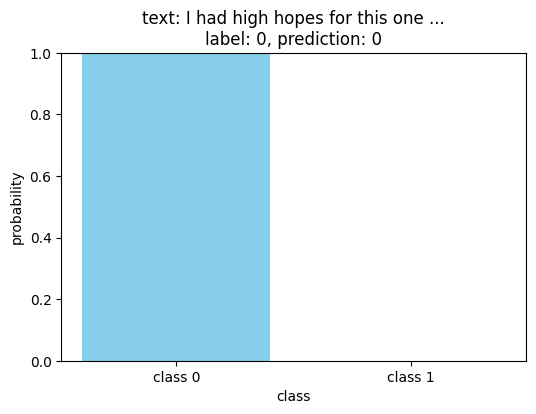

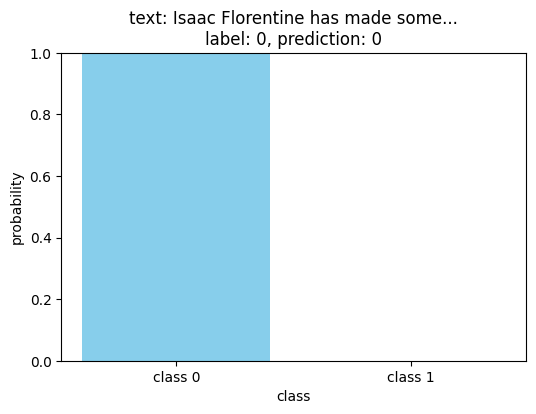

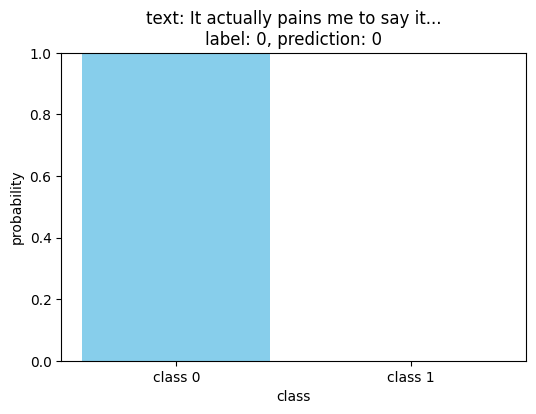

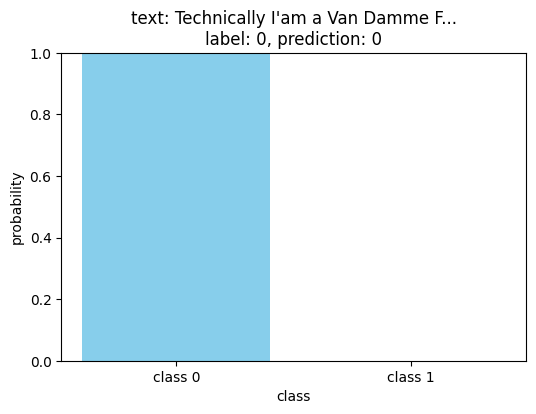

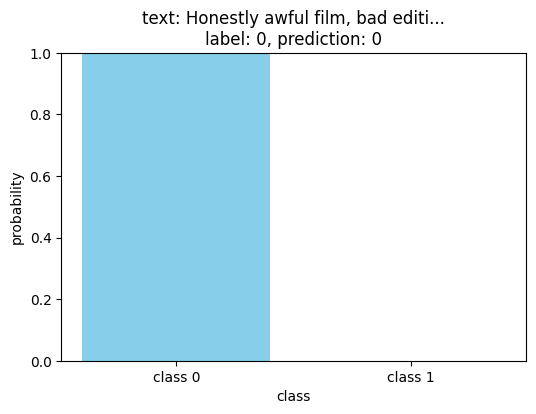

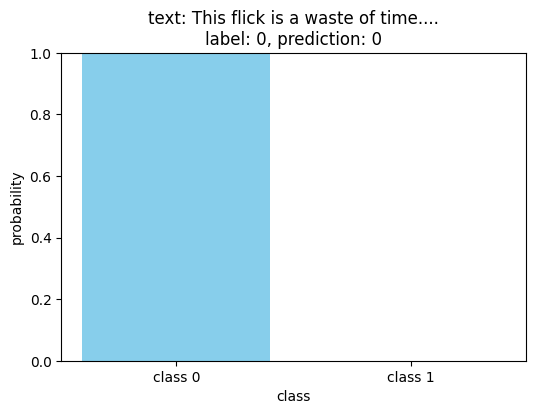

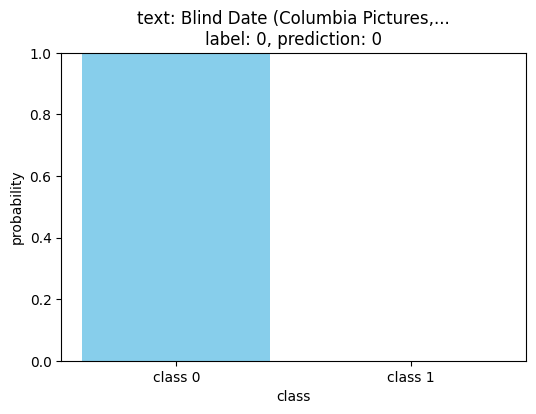

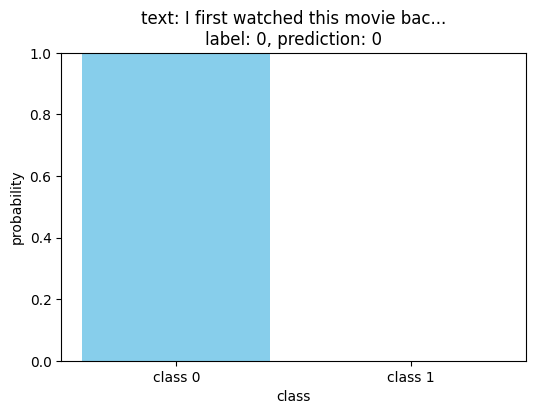

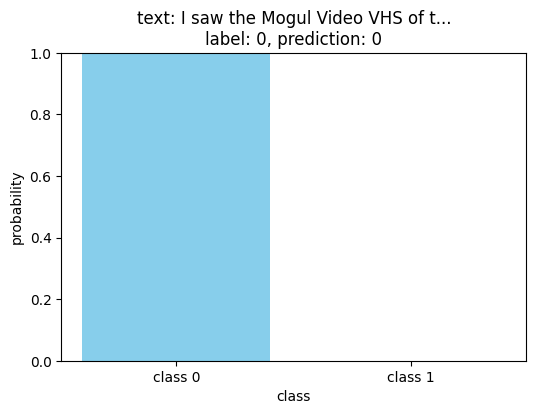

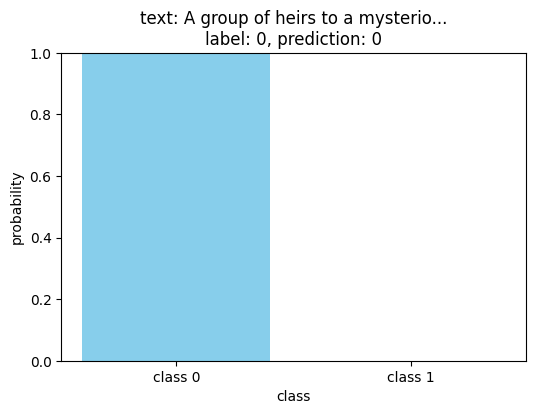

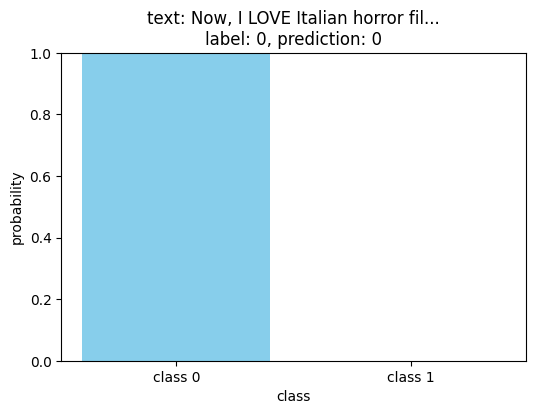

In [1]:
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from datasets import load_dataset_builder
from datasets import load_dataset

"""
Hugging FaceÏùò Transformers ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º ÏÇ¨Ïö©Ìï¥ BERT Î™®Îç∏ÏùÑ ÌôúÏö©Ìïú Í∞êÏ†ï Î∂ÑÏÑùÏùÑ ÏàòÌñâ
- `BertTokenizer: BERT Î™®Îç∏Ïóê ÎßûÍ≤å ÌÖçÏä§Ìä∏Î•º ÌÜ†ÌÅ∞ÌôîÌïòÎäî ÎèÑÍµ¨
- `get_linear_schedule_with_warmup`: ÌïôÏäµÎ•†ÏùÑ Ï°∞Ï†àÌïòÎäî Ïä§ÏºÄÏ§ÑÎü¨
- `AdamW`: Adam ÏòµÌã∞ÎßàÏù¥Ï†ÄÏùò Î≥ÄÌòïÏúºÎ°ú Í∞ÄÏ§ëÏπò Í∞êÏá†(weight decay)Î•º Ï†ÅÏö©ÌïòÎäî ÏòµÌã∞ÎßàÏù¥Ï†Ä
- `BertForSequenceClassification`: Í∞êÏ†ï Î∂ÑÏÑù Îì± Î∂ÑÎ•ò ÏûëÏóÖÏùÑ ÏúÑÌïú BERT Î™®Îç∏
"""

# 1. Îç∞Ïù¥ÌÑ∞ÏÖã Î™®Îìà: ÌÖçÏä§Ìä∏ÏôÄ Î†àÏù¥Î∏îÏùÑ Î∞õÏïÑ BERT ÏûÖÎ†• ÌòïÏãùÏúºÎ°ú Î≥ÄÌôòÌï©ÎãàÎã§.
class SentimentDataset(Dataset):

    """
    *. __init__(): Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Ï¥àÍ∏∞Ìôî 
    - texts: ÏûÖÎ†• ÌÖçÏä§Ìä∏ Î¶¨Ïä§Ìä∏
    - labels: Í∞Å ÌÖçÏä§Ìä∏Ïóê Ìï¥ÎãπÌïòÎäî Í∞êÏ†ï Î†àÏù¥Î∏î (Ïòà: Í∏çÏ†ï/Î∂ÄÏ†ï)
    - tokenizer: ÌÖçÏä§Ìä∏Î•º ÌÜ†ÌÅ∞ÌôîÌï† Îïå ÏÇ¨Ïö©Ìï† BERT ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä
    - max_len: ÌÜ†ÌÅ∞ ÏãúÌÄÄÏä§Ïùò ÏµúÎåÄ Í∏∏Ïù¥Î•º ÏßÄÏ†ï

    *. __getitem__(): Ï£ºÏñ¥ÏßÑ Ïù∏Îç±Ïä§(idx)Ïóê Ìï¥ÎãπÌïòÎäî ÌÖçÏä§Ìä∏ÏôÄ Î†àÏù¥Î∏îÏùÑ Í∞ÄÏ†∏ÏôÄ BERT ÏûÖÎ†• ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
    encoding = tokenizer.encode_plus(
    : ÌÖçÏä§Ìä∏Î•º ÌÜ†ÌÅ∞ÌôîÌïòÍ≥† BERTÍ∞Ä ÏöîÍµ¨ÌïòÎäîÎäî ÏûÖÎ†• ÌòïÏãùÏóê ÎßûÍ≤å Î≥ÄÌôò

    - add_special_tokens=True: [CLS]ÎÇò [SEP] Í∞ôÏùÄ ÌäπÎ≥Ñ ÌÜ†ÌÅ∞ Ï∂îÍ∞Ä
    - max_length: ÏµúÎåÄ Í∏∏Ïù¥Î•º ÏßÄÏ†ïÌïòÏó¨ Í∏∏Ïù¥Î•º Í≥†Ï†ï
    - padding='max_length': Í∏∏Ïù¥Í∞Ä Î∂ÄÏ°±Ìï† Í≤ΩÏö∞ Ìå®Îî©ÏùÑ Ï∂îÍ∞Ä
    - truncation=True: ÎÑàÎ¨¥ Í∏∏Î©¥ ÏûêÎ•¥Í∏∞
    - return_attention_mask=True: Ìå®Îî© Î∂ÄÎ∂ÑÏùÑ ÎßàÏä§ÌÇπÌïòÎäî Ïñ¥ÌÖêÏÖò ÎßàÏä§ÌÅ¨ ÏÉùÏÑ±
    - return_tensors='pt': Í≤∞Í≥ºÎ•º PyTorch ÌÖêÏÑúÎ°ú Î∞òÌôò

    *. return 
    ÎîïÏÖîÎÑàÎ¶¨ Î∞òÌôò
    ‚Üí Î™®Îç∏ ÌïôÏäµÏóê ÌïÑÏöîÌïú ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞(ÌÜ†ÌÅ∞ ID, Ïñ¥ÌÖêÏÖò ÎßàÏä§ÌÅ¨)ÏôÄ ÏõêÎ≥∏ ÌÖçÏä§Ìä∏, Î†àÏù¥Î∏îÏùÑ ÎîïÏÖîÎÑàÎ¶¨ ÌòïÌÉúÎ°ú Î∞òÌôò
    .flatten()ÏùÄ ÌÖêÏÑúÏùò Ï∞®ÏõêÏùÑ ÌèâÌèâÌïòÍ≤å ÎßåÎì§Ïñ¥ 1Ï∞®Ïõê Î∞∞Ïó¥Î°ú ÎßåÎì†Îã§.
    """
    # ÌÅ¥ÎûòÏä§ Ï†ïÏùò Î∞è Ï¥àÍ∏∞Ìôî
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Îç∞Ïù¥ÌÑ∞ÏÖãÏùò ÏÉòÌîå Í∞úÏàò Î∞òÌôò
    def __len__(self):
        return len(self.texts)

    #  Ï£ºÏñ¥ÏßÑ Ïù∏Îç±Ïä§(idx)Ïóê Ìï¥ÎãπÌïòÎäî ÌÖçÏä§Ìä∏ÏôÄ Î†àÏù¥Î∏îÏùÑ Í∞ÄÏ†∏ÏôÄ BERT ÏûÖÎ†• ÌòïÏãùÏúºÎ°ú Î≥ÄÌôò
    def __getitem__(self, idx):
        text = str(self.texts[idx])# self.texts[idx]Í∞Ä strÏùº ÏàòÎèÑ ÏûàÏßÄÎßå ÌòπÏãú Î™®Î•¥Îãà strÎ°ú Î≥ÄÌôò
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 2. ÌïôÏäµ Î™®Îìà: ÏóêÌè¨ÌÅ¨ Îã®ÏúÑÎ°ú Î™®Îç∏ ÌïôÏäµÏùÑ ÏßÑÌñâÌï©ÎãàÎã§.
def train_epoch(model, data_loader, optimizer, device, scheduler):

    """ 
    data_loaderÎ°úÎ∂ÄÌÑ∞ batchÎ•º ÌïòÎÇòÏî© Í∞ÄÏ†∏ÏôÄ Î™®Îç∏ÏùÑ ÌïôÏäµ
    bata_loaderÎäî train_datasetÏùÑ DataLoaderÎ°ú Î≥ÄÌôòÌïú Í≤É

    batchÏóêÏÑú input_ids Ïó¥ Ï∂îÏ∂úÌïòÏó¨ deviceÎ°ú Ïù¥Îèô
    attention_mask Ïó¥ Ï∂îÏ∂úÌïòÏó¨ deviceÎ°ú Ïù¥Îèô
    labels Ïó¥ Ï∂îÏ∂úÌïòÏó¨ deviceÎ°ú Ïù¥Îèô

    modelÏóê input_ids, attention_mask, labelsÎ•º ÏûÖÎ†•ÌïòÍ≥† Ï∂úÎ†•ÏùÑ Î∞õÏùå
    Ï∂úÎ†•ÏúºÎ°úÎ∂ÄÌÑ∞ ÏÜêÏã§Í∞íÏùÑ Í≥ÑÏÇ∞ÌïòÍ≥† total_lossÏóê ÎçîÌï®
    ÏÜêÏã§Í∞íÏúºÎ°ú Ïó≠Ï†ÑÌåå ÏàòÌñâÌïòÏó¨ Í∞ÄÏ§ëÏπò ÏóÖÎç∞Ïù¥Ìä∏
    Ïä§ÏºÄÏ§ÑÎü¨Î°ú ÌïôÏäµÎ•† Ï°∞Ï†àÌïòÎ©∞, ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï¥àÍ∏∞Ìôî 
    ÏòµÌã∞ÎßàÏù¥Ï†Ä Ï¥àÍ∏∞ÌôîÌïòÎäî Ïù¥Ïú† : Í∞Å Î∞∞ÏπòÎßàÎã§ ÏÉàÎ°úÏö¥ Í∞ÄÏ§ëÏπòÎ°ú ÏóÖÎç∞Ïù¥Ìä∏ÌïòÍ∏∞ ÏúÑÌï¥ Í∑∏Î†àÎîîÏñ∏Ìä∏Î•º Ï¥àÍ∏∞ÌôîÌï®. 
    
    (Ï§ëÏöî : Í∞ÄÏ§ëÏπòÎ•º Ï¥àÍ∏∞ÌôîÌïòÎäî Í≤ÉÏù¥ ÏïÑÎãàÎùº Í∑∏Î†àÎîîÏñ∏Ìä∏Î•º Ï¥àÍ∏∞ÌôîÌïòÎäî Í≤ÉÏûÑ !!!)

    üîπ 1. loss.backward()Í∞Ä Î¨¥ÏóáÏùÑ ÌïòÎäîÍ∞Ä?
      loss.backward()
      PyTorchÏóêÏÑúÎäî Ïó≠Ï†ÑÌåå(Backpropagation) Î•º ÏàòÌñâÌïòÎ©¥,
      Î™®Îç∏Ïùò Í∞Å ÌååÎùºÎØ∏ÌÑ∞(Í∞ÄÏ§ëÏπò)Ïóê ÎåÄÌïú Í∑∏ÎûòÎîîÏñ∏Ìä∏(gradient)Í∞Ä ÎàÑÏ†ÅÎê®.
      Ï¶â, loss.backward()Î•º Ìò∏Ï∂úÌïòÎ©¥ ÌòÑÏû¨ Î∞∞Ïπò(batch)Ïóê ÎåÄÌïú Í∑∏ÎûòÎîîÏñ∏Ìä∏Í∞Ä Í≥ÑÏÇ∞ÎêòÏñ¥ Î™®Îç∏Ïùò grad ÏÜçÏÑ±Ïóê Ï†ÄÏû•Îê®.

    üîπ 2. optimizer.step()Îäî Î¨¥ÏóáÏùÑ ÌïòÎäîÍ∞Ä?
      optimizer.step()ÏùÄ ÌòÑÏû¨ Î∞∞ÏπòÏóêÏÑú Í≥ÑÏÇ∞Îêú Í∑∏ÎûòÎîîÏñ∏Ìä∏Î•º Ïù¥Ïö©Ìï¥ Î™®Îç∏Ïùò Í∞ÄÏ§ëÏπòÎ•º ÏóÖÎç∞Ïù¥Ìä∏

    üîπ 3. optimizer.zero_grad()Í∞Ä ÌïÑÏöîÌïú Ïù¥Ïú†
      PyTorchÏùò Í∏∞Î≥∏ ÎèôÏûëÏùÄ Í∑∏ÎûòÎîîÏñ∏Ìä∏(gradient)Í∞Ä ÎàÑÏ†ÅÎêòÎäî Í≤É.
      Ï¶â, loss.backward()Î•º Ìò∏Ï∂úÌï† ÎïåÎßàÎã§ Ïù¥Ï†Ñ Î∞∞ÏπòÏùò Í∑∏ÎûòÎîîÏñ∏Ìä∏Í∞Ä ÎàÑÏ†ÅÎêòÏñ¥ Ï†êÏ†ê Ïª§Ïßê.
      Ïù¥Î•º Î∞©ÏßÄÌïòÎ†§Î©¥ Îß§ Î∞∞ÏπòÎßàÎã§ optimizer.zero_grad()Î•º Ìò∏Ï∂úÌïòÏó¨ Í∑∏ÎûòÎîîÏñ∏Ìä∏Î•º Ï¥àÍ∏∞ÌôîÌï¥Ïïº Ìï®.

      Î∞∞ÏπòÎ•º Ïó¨Îü¨ Î≤à ÎèåÎ¶¨Îäî Ïù¥Ïú†Îäî Í∞ÄÏ§ëÏπòÍ∞Ä ÏïÑÎãàÎùº Í∑∏ÎûòÎîîÏñ∏Ìä∏(Gradient) Î•º Îã§Î£®Í∏∞ ÏúÑÌï¥ÏÑú.
      optimizer.zero_grad()Îäî Í∞ÄÏ§ëÏπò(Weights)Î•º Ï¥àÍ∏∞ÌôîÌïòÎäî Í≤ÉÏù¥ ÏïÑÎãàÎùº, Í∑∏ÎûòÎîîÏñ∏Ìä∏(Gradient)Î•º Ï¥àÍ∏∞ÌôîÌïòÎäî Í≤É.
      Ï¶â, Í∞ÄÏ§ëÏπòÎäî Í≥ÑÏÜçÌï¥ÏÑú ÏóÖÎç∞Ïù¥Ìä∏ÎêòÎ©∞, Í∑∏ÎûòÎîîÏñ∏Ìä∏Îäî Îß§ Î∞∞ÏπòÎßàÎã§ Ï¥àÍ∏∞ÌôîÎêòÎäî Íµ¨Ï°∞.
    """

    model.train()
    total_loss = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return total_loss / len(data_loader)

# 3. ÌèâÍ∞Ä Î™®Îìà: Î™®Îç∏Ïùò Ï†ïÌôïÎèÑÎ•º ÌèâÍ∞ÄÌï©ÎãàÎã§.
def eval_model(model, data_loader, device):

    """ 
    Î™®Îç∏ÏùÑ ÌèâÍ∞ÄÌïòÎäî Ìï®Ïàò

    data_loaderÎ°úÎ∂ÄÌÑ∞ batchÎ•º ÌïòÎÇòÏî© Í∞ÄÏ†∏ÏôÄ Î™®Îç∏ÏùÑ ÌèâÍ∞Ä
    batchÏóêÏÑú input_ids Ïó¥ Ï∂îÏ∂úÌïòÏó¨ deviceÎ°ú Ïù¥Îèô
    batchÏóêÏÑú attention_mask Ïó¥ Ï∂îÏ∂úÌïòÏó¨ deviceÎ°ú Ïù¥Îèô
    batchÏóêÏÑú labels Ïó¥ Ï∂îÏ∂úÌïòÏó¨ deviceÎ°ú Ïù¥Îèô
    modelÏóê input_ids, attention_maskÏùÑ ÏûÖÎ†•ÌïòÍ≥† Ï∂úÎ†•ÏùÑ Î∞õÏùå
    Î™®Îç∏ÏùÑ ÌèâÍ∞ÄÌïòÍ∏∞ ÏúÑÌï¥ torch.no_grad()Î°ú Í∞êÏã∏ÏÑú Í∑∏ÎûòÎîîÏñ∏Ìä∏ Í≥ÑÏÇ∞ÏùÑ ÎπÑÌôúÏÑ±Ìôî
    Î™®Îç∏Ïùò Ï∂úÎ†•ÏóêÏÑú Í∞ÄÏû• ÌÅ∞ Í∞íÏùò Ïù∏Îç±Ïä§Î•º ÏòàÏ∏°Í∞íÏúºÎ°ú ÏÇ¨Ïö© (Î™®Îç∏Ïùò Ï∂úÎ†•ÏùÄ Î°úÏßì Í∞íÏù¥Î©∞, Í∞ÄÏû• ÌÅ∞ Í∞íÏùò Ïù∏Îç±Ïä§Í∞Ä ÏòàÏ∏°Í∞í)

    logit Ïù¥ÎûÄ? 
    Î°úÏßìÏùÄ Softmax Ìï®Ïàò Ï†ÅÏö© Ï†ÑÏùò Ï∂úÎ†•Í∞íÏúºÎ°ú, Î™®Îç∏Ïù¥ ÏòàÏ∏°Ìïú Í∞Å ÌÅ¥ÎûòÏä§Ïùò Ï†êÏàò(score) Î•º ÏùòÎØ∏.

    ‚úî outputs.logitsÎäî Î™®Îç∏Ïù¥ ÏòàÏ∏°Ìïú ÏõêÏãú Ï†êÏàò(Softmax Ï†ÅÏö© Ï†Ñ)Ïù¥Î©∞, ÌôïÎ•†Ïù¥ ÏïÑÎãò.
    ‚úî torch.max(outputs.logits, dim=1)Î•º ÏÇ¨Ïö©ÌïòÎ©¥ Í∞ÄÏû• ÎÜíÏùÄ Ï†êÏàòÎ•º Í∞ÄÏßÑ ÌÅ¥ÎûòÏä§Î•º ÏòàÏ∏°Í∞íÏúºÎ°ú Î≥ÄÌôò Í∞ÄÎä•.
    ‚úî ÌôïÎ•†Ïù¥ ÌïÑÏöîÌïòÎã§Î©¥ Softmax(Îã§Ï§ë Î∂ÑÎ•ò) ÎòêÎäî Sigmoid(Ïù¥ÏßÑ Î∂ÑÎ•ò)Î•º Ï†ÅÏö©Ìï¥Ïïº Ìï®.

    Ï¶â, logitsÎäî "Î™®Îç∏Ïùò ÏµúÏ¢Ö ÏòàÏ∏° Ï†êÏàò"Ïù¥Î©∞, ÌôïÎ•†Ïù¥ ÏïÑÎãå ÏõêÏãú Í∞íÏù¥ÎØÄÎ°ú Ï∂îÍ∞Ä Î≥ÄÌôòÏù¥ ÌïÑÏöîÌï† Ïàò ÏûàÎã§Îã§!

    ÏòàÏ∏°Í∞í(logitÏù¥ Í∞ÄÏû• ÌÅ∞Í∞íÏùò )Í≥º Ïã§Ï†ú Î†àÏù¥Î∏îÏùÑ ÎπÑÍµêÌïòÏó¨ Ï†ïÌôïÌïú ÏòàÏ∏° ÏàòÎ•º Í≥ÑÏÇ∞

    outputÏùÄ Í∞ùÏ≤¥Ïù¥Í∏∞ ÎïåÎ¨∏Ïóê .logitÍ≥º Í∞ôÏùÄ Í∏∞Îä•ÏùÑ ÏÇ¨Ïö©Ìï† Ïàò ÏûàÏùå

    Î¶¨ÌÑ¥ÏùÄ Ï†ïÌôïÌûà ÎßûÏ∂ò ÏòàÏ∏° ÏàòÎ•º Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ Í∞úÏàòÎ°ú ÎÇòÎà† ÌèâÍ∑† Ï†ïÌôïÎèÑÎ•º Í≥ÑÏÇ∞
    """
    model.eval()
    correct_predictions = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total += labels.size(0)

    return correct_predictions.double() / total

# 4. Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉòÌîå ÏãúÍ∞ÅÌôî: Îç∞Ïù¥ÌÑ∞ÏÖãÏùò ÏÉòÌîå Íµ¨Ï°∞Î•º Ï∂úÎ†•Ìï©ÎãàÎã§. Ï¥ù 3Í∞úÎßå Ï∂úÎ†• 
def visualize_dataset_sample(dataset, num_samples=3):
    print("=== dataset sample ===")
    for i in range(num_samples):
        sample = dataset[i]
        print(f"sample {i+1}:")
        print("text:", sample['text'])
        print("input token IDs:", sample['input_ids'])
        print("attention mask:", sample['attention_mask'])
        print("label:", sample['labels'])
        print("-----")

# 5. Î™®Îç∏ Í≤∞Í≥º ÏãúÍ∞ÅÌôî (ÌÖçÏä§Ìä∏ Ï∂úÎ†•): ÏûÖÎ†• ÌÖçÏä§Ìä∏ÏôÄ ÏòàÏ∏°Îêú Í≤∞Í≥º, Ïã§Ï†ú Î†àÏù¥Î∏î Î∞è Î°úÏßìÏùÑ Ï∂úÎ†•Ìï©ÎãàÎã§.
def visualize_model_results(model, data_loader, device, num_samples=1):
    model.eval()
    print("=== model result sample ===")
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i >= num_samples:
                break
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            for j in range(len(batch['text'])):
                print(f"input text: {batch['text'][j]}")
                print(f"prediction: {preds[j].item()}, label: {labels[j].item()}")
                print(f"logit: {outputs.logits[j].cpu().numpy()}")
                print("-----")

# 6. Î™®Îç∏ Í≤∞Í≥º ÏãúÍ∞ÅÌôî (Í∑∏ÎûòÌîÑ): MatplotlibÏùÑ ÏÇ¨Ïö©Ìï¥ Í∞Å ÌÅ¥ÎûòÏä§Ïùò ÌôïÎ•†ÏùÑ ÎßâÎåÄÍ∑∏ÎûòÌîÑÎ°ú Ï∂úÎ†•Ìï©ÎãàÎã§.
def visualize_model_results_with_plot(model, data_loader, device, num_samples=1):
    model.eval()
    print("=== Î™®Îç∏ Í≤∞Í≥º ÏãúÍ∞ÅÌôî (Í∑∏ÎûòÌîÑ) ===")
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            if i >= num_samples:
                break
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            for j in range(len(batch['text'])):
                probs = torch.softmax(outputs.logits[j], dim=0).cpu().numpy()
                classes = [f"class {k}" for k in range(len(probs))]
                plt.figure(figsize=(6,4))
                plt.bar(classes, probs, color='skyblue')
                plt.title(f"text: {batch['text'][j][:30]}...\nlabel: {labels[j].item()}, prediction: {torch.argmax(outputs.logits[j]).item()}")
                plt.xlabel("class")
                plt.ylabel("probability")
                plt.ylim(0, 1)
                plt.show()

def main():

    """ 
    * Hyperparameters ÏÑ§Ï†ï
    - PRE_TRAINED_MODEL_NAME: ÏÇ¨Ï†Ñ ÌõàÎ†®Îêú BERT Î™®Îç∏ Ïù¥Î¶Ñ
    - MAX_LEN: ÌÜ†ÌÅ∞ ÏãúÌÄÄÏä§Ïùò ÏµúÎåÄ Í∏∏Ïù¥
    - BATCH_SIZE: Î∞∞Ïπò ÌÅ¨Í∏∞
    - EPOCHS: ÏóêÌè¨ÌÅ¨ Ïàò
    - DEVICE: ÏÇ¨Ïö©Ìï† ÎîîÎ∞îÏù¥Ïä§ (GPU ÎòêÎäî CPU)

    * ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÏôÄ Î™®Îç∏ Î°úÎìú
    - tokenizer: tokenizerÎäî Hugging FaceÏùò BertTokenizer ÌÅ¥ÎûòÏä§ Í∞ùÏ≤¥
    üîπ tokenizer Í∞ùÏ≤¥Ïùò Ïó≠Ìï†
        - ÌÖçÏä§Ìä∏Î•º BERT Î™®Îç∏Ïù¥ Ïù¥Ìï¥Ìï† Ïàò ÏûàÎäî ÌòïÏãù(ÌÜ†ÌÅ∞ ID)Î°ú Î≥ÄÌôò
        - BERTÍ∞Ä ÏöîÍµ¨ÌïòÎäî ÌäπÏàò ÌÜ†ÌÅ∞([CLS], [SEP]) Ï∂îÍ∞Ä
        - Ìå®Îî©(Padding) Î∞è ÏãúÌÄÄÏä§ Í∏∏Ïù¥ Ï°∞Ï†ï
        - Ïñ¥ÌÖêÏÖò ÎßàÏä§ÌÅ¨ ÏÉùÏÑ± (Ìå®Îî©Îêú Î∂ÄÎ∂ÑÏùÑ Î¨¥ÏãúÌïòÎèÑÎ°ù ÏÑ§Ï†ï)
    Ï¶â, tokenizerÎäî ÌÖçÏä§Ìä∏Î•º BERT Î™®Îç∏Ïù¥ Ïù¥Ìï¥Ìï† Ïàò ÏûàÎäî ÌòïÏãùÏúºÎ°ú Î≥ÄÌôòÌïòÎäî Ïó≠Ìï†ÏùÑ Ìï®. (Î¨∏Ïû•ÏùÑ Ïà´ÏûêÎ°ú Î≥ÄÌôò)

    - model: modelÏùÄ Hugging FaceÏùò BertForSequenceClassification ÌÅ¥ÎûòÏä§ Í∞ùÏ≤¥
    üîπ model Í∞ùÏ≤¥Ïùò Ïó≠Ìï†
        - BertModelÏùÑ Í∏∞Î∞òÏúºÎ°ú Ìïú Î¨∏Ïû• Î∂ÑÎ•ò Î™®Îç∏
        - ÏÇ¨Ï†Ñ ÌïôÏäµÎêú BERT Î™®Îç∏Ïùò ÎßàÏßÄÎßâ Î†àÏù¥Ïñ¥ ÏúÑÏóê Î∂ÑÎ•òÏö© ÏÑ†Ìòï(Linear) Î†àÏù¥Ïñ¥ Ï∂îÍ∞Ä
        - ÏûÖÎ†•Îêú Î¨∏Ïû•Ïùò Í∞êÏ†ï Î∂ÑÏÑù(Í∏çÏ†ï/Î∂ÄÏ†ï) ÏàòÌñâ
    Ï∂úÎ†• : [1.23, -0.98]: Í∏çÏ†ï(1.23), Î∂ÄÏ†ï(-0.98)Ïùò Î°úÏßì Í∞í
    „Ñ¥ torch.argmax(outputs.logits, dim=1)ÏùÑ ÌïòÎ©¥ ÏµúÏ¢Ö ÏòàÏ∏° Í≤∞Í≥ºÎ•º ÏñªÏùÑ Ïàò ÏûàÏùå.

    * IMDb Í∞êÏ†ï Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú
    Hugging FaceÏùò datasets ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º ÏÇ¨Ïö©Ìï¥ IMDb Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Î°úÎìú


    accuracy_tensor.item()Ïùò ÏùòÎØ∏
    .item()ÏùÑ Ìò∏Ï∂úÌïòÎ©¥ ÌÖêÏÑúÎ•º PythonÏùò Ïà´Ïûê(float) Í∞íÏúºÎ°ú Î≥ÄÌôò.
    „Ñ¥ .item()ÏùÑ ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÏúºÎ©¥ tensor(0.8923)Ï≤òÎüº Ï∂úÎ†•Îê®.
    „Ñ¥ .item()ÏùÑ ÏÇ¨Ïö©ÌïòÎ©¥ 0.8923Ïù¥ÎùºÎäî ÏàúÏàòÌïú Python float Í∞íÏù¥ Îê®.


    """
    
    # ----------------------------------------------------------------------------
    # ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
    PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
    MAX_LEN = 128
    BATCH_SIZE = 16
    EPOCHS = 3
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ----------------------------------------------------------------------------
    # ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÏôÄ Î™®Îç∏ Î°úÎìú
    tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
    model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=2)
    model = model.to(DEVICE)

    # ----------------------------------------------------------------------------
    # IMDb Í∞êÏ†ï Î∂ÑÏÑù Îç∞Ïù¥ÌÑ∞ÏÖã Î°úÎìú (ÌõàÎ†® + ÌÖåÏä§Ìä∏ Î∂ÑÎ¶¨)
    # ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º Ïì∞ÏßÄ ÏïäÍ≥†, HTTP API ÏöîÏ≤≠ÏùÑ ÌÜµÌï¥ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Îã§Ïö¥Î°úÎìú Î∞õÏùÑ ÏàòÎèÑ ÏûàÏùå
    # Ïó¨Í∏∞ÏÑúÎäî ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º ÌÜµÌï¥ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Îã§Ïö¥Î°úÎìúÌïòÎèÑÎ°ù Ìï®
    print("Downloading IMDb dataset...")
    dataset = load_dataset("imdb") # Hugging FaceÏùò datasets ÎùºÏù¥Î∏åÎü¨Î¶¨Î•º ÌÜµÌï¥ APIÎ•º Ìò∏Ï∂ú

    # ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ (25,000Í∞ú Ï§ë 500Í∞úÎßå ÏÇ¨Ïö©)
    train_texts = dataset["train"]["text"][:500]
    train_labels = dataset["train"]["label"][:500]

    # ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ (25,000Í∞ú Ï§ë 500Í∞úÎßå ÏÇ¨Ïö©)
    test_texts = dataset["test"]["text"][:500]
    test_labels = dataset["test"]["label"][:500]

    print(f"Training data size: {len(train_texts)}")
    print(f"Test data size: {len(test_texts)}")

    # ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖã Î∞è DataLoader ÏÉùÏÑ±
    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, MAX_LEN)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖã Î∞è DataLoader ÏÉùÏÑ± (ÌõàÎ†®Í≥º Î≥ÑÍ∞úÎ°ú Ïú†ÏßÄ)
    test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, MAX_LEN)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # --------------------------------------------------------------
    # Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉòÌîå ÏãúÍ∞ÅÌôî (ÌõàÎ†® Îç∞Ïù¥ÌÑ∞)
    visualize_dataset_sample(train_dataset, num_samples=3)

    #--------------------------------------------------------------
    # ÏòµÌã∞ÎßàÏù¥Ï†Ä Î∞è Ïä§ÏºÄÏ§ÑÎü¨ ÏÑ§Ï†ï
    optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # --------------------------------------------------------------
    # ÏóêÌè¨ÌÅ¨ Îã®ÏúÑÎ°ú Î™®Îç∏ ÌïôÏäµ Î∞è ÌèâÍ∞Ä
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch+1}/{EPOCHS}')
        train_loss = train_epoch(model, train_loader, optimizer, DEVICE, scheduler)
        print(f'Train loss: {train_loss:.4f}')

        # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú Ï†ïÌôïÎèÑ ÌèâÍ∞Ä (Í≥ºÏ†ÅÌï© Ïó¨Î∂Ä ÌôïÏù∏)
        train_accuracy = eval_model(model, train_loader, DEVICE)
        print(f'Training Accuracy: {train_accuracy.item()*100:.2f}%')

        # ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖãÏóêÏÑú Ï†ïÌôïÎèÑ ÌèâÍ∞Ä (Ïã§Ï†ú ÏÑ±Îä• ÌôïÏù∏)
        test_accuracy = eval_model(model, test_loader, DEVICE)
        print(f'Test Accuracy: {test_accuracy.item()*100:.2f}%')

    # --------------------------------------------------------------
    # Î™®Îç∏ Í≤∞Í≥º ÏãúÍ∞ÅÌôî (ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏóêÏÑú ÏÉòÌîå ÌôïÏù∏)
    visualize_model_results(model, test_loader, DEVICE, num_samples=1)
    visualize_model_results_with_plot(model, test_loader, DEVICE, num_samples=1)

if __name__ == '__main__':
    main()
